# Проект по анализу данных с сайта Новости ООН

## Часть 1. Сбор данных

### Реализация парсера

In [ ]:
import re
import time
import datetime
import pandas as pd
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup

!pip install selenium
from selenium import webdriver
from dataclasses import dataclass
import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
SLEEP = 1
# MAX_DEPTH_REGION = [518, 369, 458, 455, 1133]
# DEPTH = 369 # Для регионов
DEPTH = 369
BASE_URL = "https://news.un.org/ru/news"
REGION = ["asia-pacific", "americas", "africa", "middle-east", "europe"]
HOW_G = "/region/"

In [ ]:
# Извлечение данных со страницы
def get_page(page, element):
    info = []
    response = requests.get(BASE_URL + HOW_G + element + f"?page={page}")
    soup = BeautifulSoup(response.content, "html.parser")
    articles = soup.find_all("article", {"role": "article"})
    # Извлечение заголовка для одной статьи
    for ar in articles:
        title = ar.find(
            "span",
            {"class": "field field--name-title field--type-string field--label-hidden"},
        ).text
        # Извлечение даты публикации для одной статьи
        date = ar.find("time").get("datetime")[:10]
        # Извлечение ссылки для одной статьи
        link = BASE_URL[:-8] + ar.find("a").get("href")
        # Извлечение вступительного текста одной статьи
        response_one = requests.get(link)
        soup_one = BeautifulSoup(response_one.content, "html.parser")
        abstract = soup_one.find(
            "div", {"class": "views-field views-field-field-news-story-lead"}
        ).text
        # Извлечение полного текста одной статьи (без заголовков, источников, таблиц)
        try:
            text = ""
            text_list = soup_one.find(
                "div",
                {
                    "class": "clearfix text-formatted field field--name-field-text-column field--type-text-long field--label-hidden field__item"
                },
            ).find_all(
                [
                    "p",
                    "h2",
                    "h3",  # Добавление в текст заголовков и подзаголовков самого текста
                ]
            )
            for i in text_list:
                text += i.text + "\n"
        except AttributeError:
            text = None
        time.sleep(SLEEP)

        row = {
            "url": link,
            "title": title,
            "date": date,
            "abstract": abstract,
            "text": text,
            "regions": element,
        }
        info.append(row)
    time.sleep(SLEEP)
    return info

In [ ]:
# Сбор данных с сайта по регионам
infa = []
for element in REGION:
    print(element)
    pages = range(DEPTH)
    for page in tqdm(pages):
        infa.extend(get_page(page, element))
        time.sleep(SLEEP)

In [ ]:
df = pd.DataFrame(infa)
df.to_pickle("df_regions.p", compression="gzip")

Опытным путем было выяснено, что у некоторых статей отсутствует полный текст. Их придется удалить.

In [ ]:
# Выводим строки со значение текста None
df[df["text"].isna()]

,url,title,date,abstract,text,regions
7858,https://news.un.org/ru/story/2018/02/1322941,Вооруженные группы в Южном Судане выпустили 30...,2018-02-07,"Вооруженные группы, действующие в Южном Судане...",None,africa


In [ ]:
# Изначальнаф форма датасета
df.shape

(18444, 6)

Лишь одна статья не имеет полного текста. Удаляем ее.

In [ ]:
# Удаляем статьи со None
df = df.dropna()

In [ ]:
# Форма датасета
df.shape

(18443, 6)

В итоге мы удалили 1 статью, у которой отсутствует полный текст.

Теперь проверим, есть ли дупликаты.

In [ ]:
duplicateRows = df[df.duplicated(["url"])]
duplicateRows

,url,title,date,abstract,text,regions
7593,https://news.un.org/ru/story/2020/04/1376472,Полицейские ООН помогают местным властям борот...,2020-04-20,Полиция ООН - на передовой в борьбе с коронави...,Об этом в интервью Службе новостей ООН сообщи...,africa
7649,https://news.un.org/ru/story/2019/08/1361951,ИГИЛ активно осваивает западную Африку и Азию,2019-08-27,"Триста миллионов долларов – таков «бюджет», на...","Потерпев военное поражение, ИГИЛ преобразуется...",africa


Удалим повторы статей, при этом распределим их так, чтобы нанести наименьший ущерб сбаоансированности категорий.

In [ ]:
# Удаление повторяющихся статей с их распределением по наменее частотным регионам
for i in tqdm(df["url"][:]):
    coun = len(df[df["url"] == i])
    if coun > 1:
        region = list(df["regions"][df["url"] == i])
        region_in_df = df["regions"][df["url"] == i].index.values.astype(int)
        t = []
        for j in region:
            t.append(len(df[df["regions"] == j]))
        tipic_max_ind = t.index(max(t))
        df.drop(labels=[region_in_df[tipic_max_ind]], axis=0, inplace=True)

  0%|          | 0/18443 [00:00<?, ?it/s]

In [ ]:
# Форма окончательного датасета
df.shape

(18441, 6)

Получается, мы удалили 2 повторяющиеся статьи.

### Первичный анализ данных

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Основные описательные статистики + визуальный анализ данных. Важно отметить интересные моменты в ваших данных до проведения исследования:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- отметить моменты, которые позволят до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.
---

- Распределение категорий
- Распределение времени новостей
- Распределение по длине заголовка
- Распределение по длине вступительного текста
- Распределение по длине основного текста
- Ключевые слова по каждой из тематик

In [ ]:
df = pd.read_pickle("df_regions.p", compression="gzip")

In [ ]:
# Форма датасета
df.shape

(18441, 6)

In [ ]:
df.head()

,url,title,date,abstract,text,regions
0,https://news.un.org/ru/story/2023/10/1446267,В ООН призвали Пакистан прекратить депортацию ...,2023-10-27,План Пакистана по депортации «нелегальных» ино...,В настоящее время в Пакистане проживает более ...,asia-pacific
1,https://news.un.org/ru/story/2023/10/1446182,ООН: без поставок топлива гуманитарные операци...,2023-10-25,Агентство ООН по оказанию помощи палестинским ...,Больницы в Газе также вынуждены закрываться од...,asia-pacific
2,https://news.un.org/ru/story/2023/10/1446132,"В Газе на исходе топливо, система здравоохране...",2023-10-24,На 17-й день кризиса между Газой и Израилем гу...,Всемирная организация здравоохранения сообщает...,asia-pacific
3,https://news.un.org/ru/story/2023/10/1446127,"Израиль, две недели спустя: шок, горе и пробле...",2023-10-24,Спустя две недели после нападения ХАМАС на Изр...,Специальный представитель Всемирной организаци...,asia-pacific
4,https://news.un.org/ru/story/2023/10/1446067,Число погибших в Газе превысило 5000 человек,2023-10-23,Число погибших в результате израильских авиауд...,Гендиректор Всемирной организации здравоохране...,asia-pacific


In [ ]:
# Размер каждой категории
df.regions.value_counts()

middle-east     3690
europe          3690
asia-pacific    3689
africa          3688
americas        3684
Name: regions, dtype: int64

Наши категории сбалансированы, так как мы настроили парсер на одинаковую глубину для каждой категории. Благодаря чему, каждая категория имеет примерно одинаковое количество статей - 3684-3690.


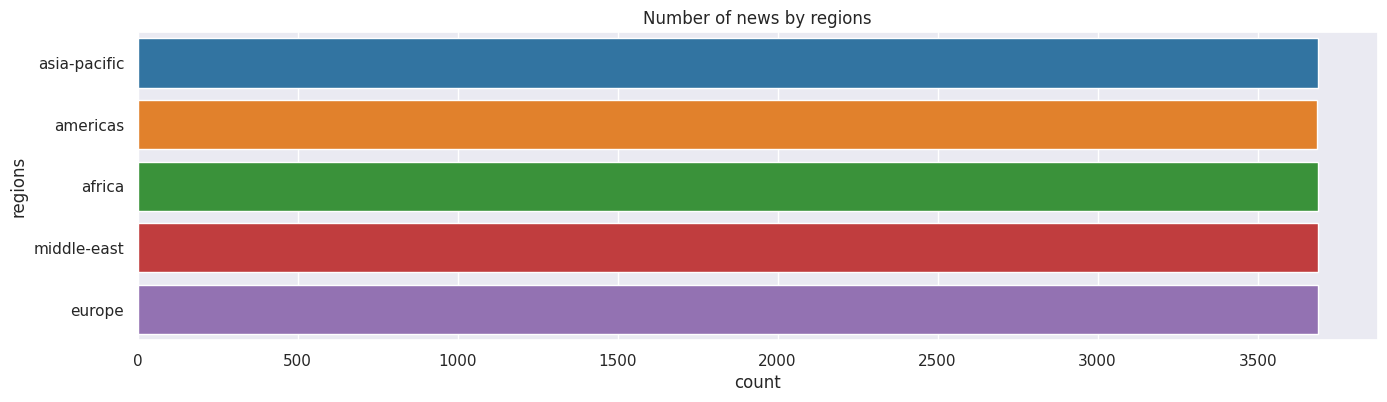

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(y=df["regions"], palette="tab10", ax=ax)
plt.title("Number of news by regions");

Сама по себе дата как строка не является признаком, однако ее компоненты могут играть важную роль в работе модели. Поэтому мы преобразуем строковую дату в формат datetime и добавим к нашим признакам год, месяц и день недели.

In [ ]:
df["date"] = pd.to_datetime(df.date)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.strftime("%B")
df["weekday"] = df["date"].dt.strftime("%A")

Какие выводы можно сделать по графикам ниже:
- Все новости относятся к разным годам: с 2003 по 2023. Без пропусков.
- Больше всего новостей приходится на 2016 год, а также на конец года - осень (Лидеры: Сентябрь и Октябрь). В течение недели больше всего новостей в среду-четверг, хотя различия при исключении выходных не кажутся большими.
- Меньше всего новостей в первые годы (2003 - 2006), в выходные.

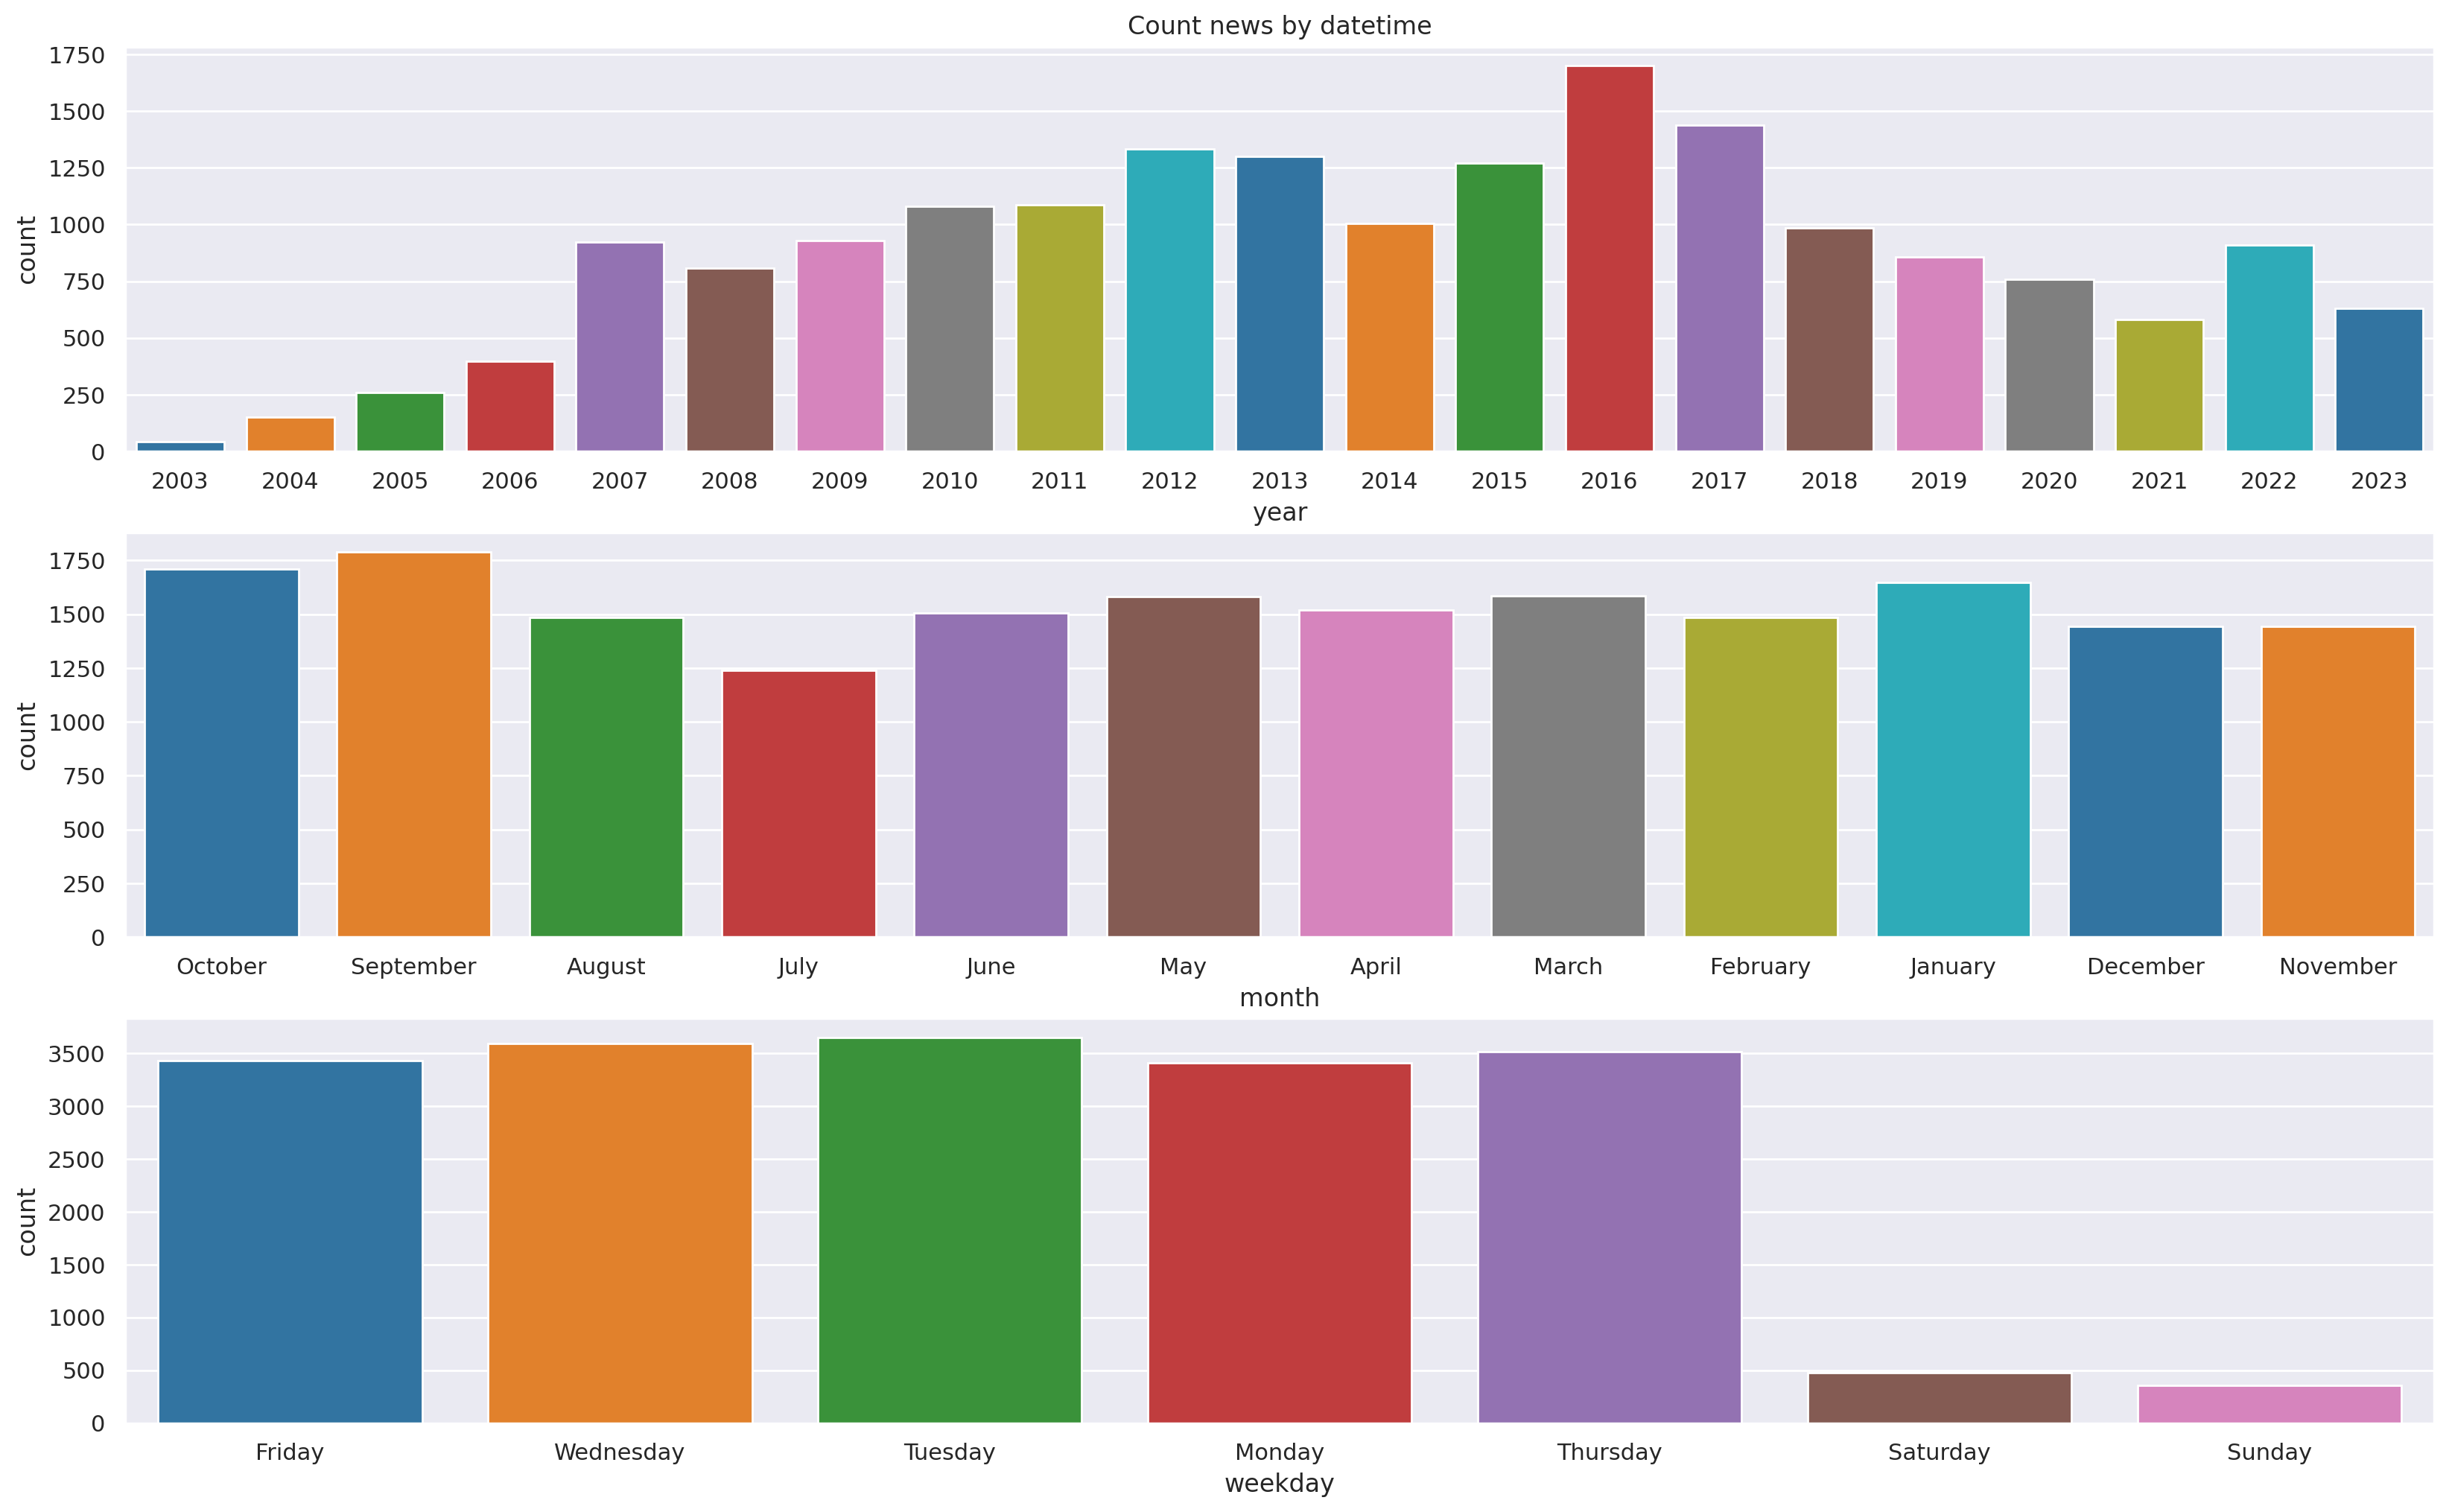

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month", "weekday"]):
    sns.countplot(
        x=df[col],
        palette="tab10",
        ax=axs[ind]
        # , order=df[col].value_counts(ascending=True).index
    )
axs[0].set_title("Count news by datetime");

Посчитаем длину заголовков, вступительного и основного текста.

In [ ]:
df["len_title"] = df["title"].str.len()
df["len_abstract"] = df["abstract"].str.len()
df["len_text"] = df["text"].str.len()

Посмотрим, как они выглядят в разрезе каждой категории.

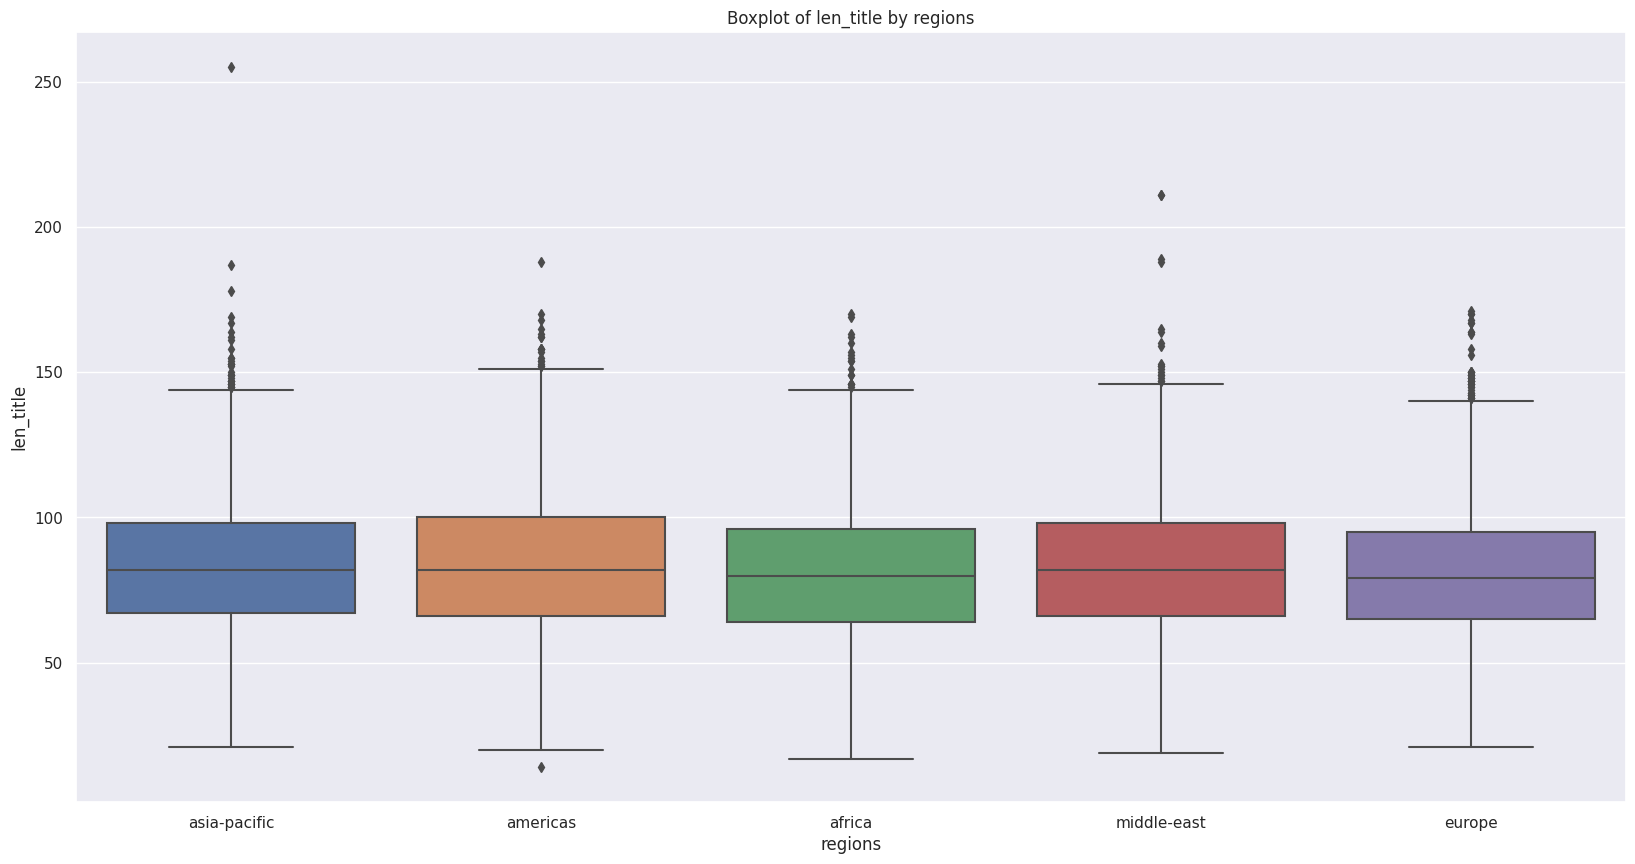

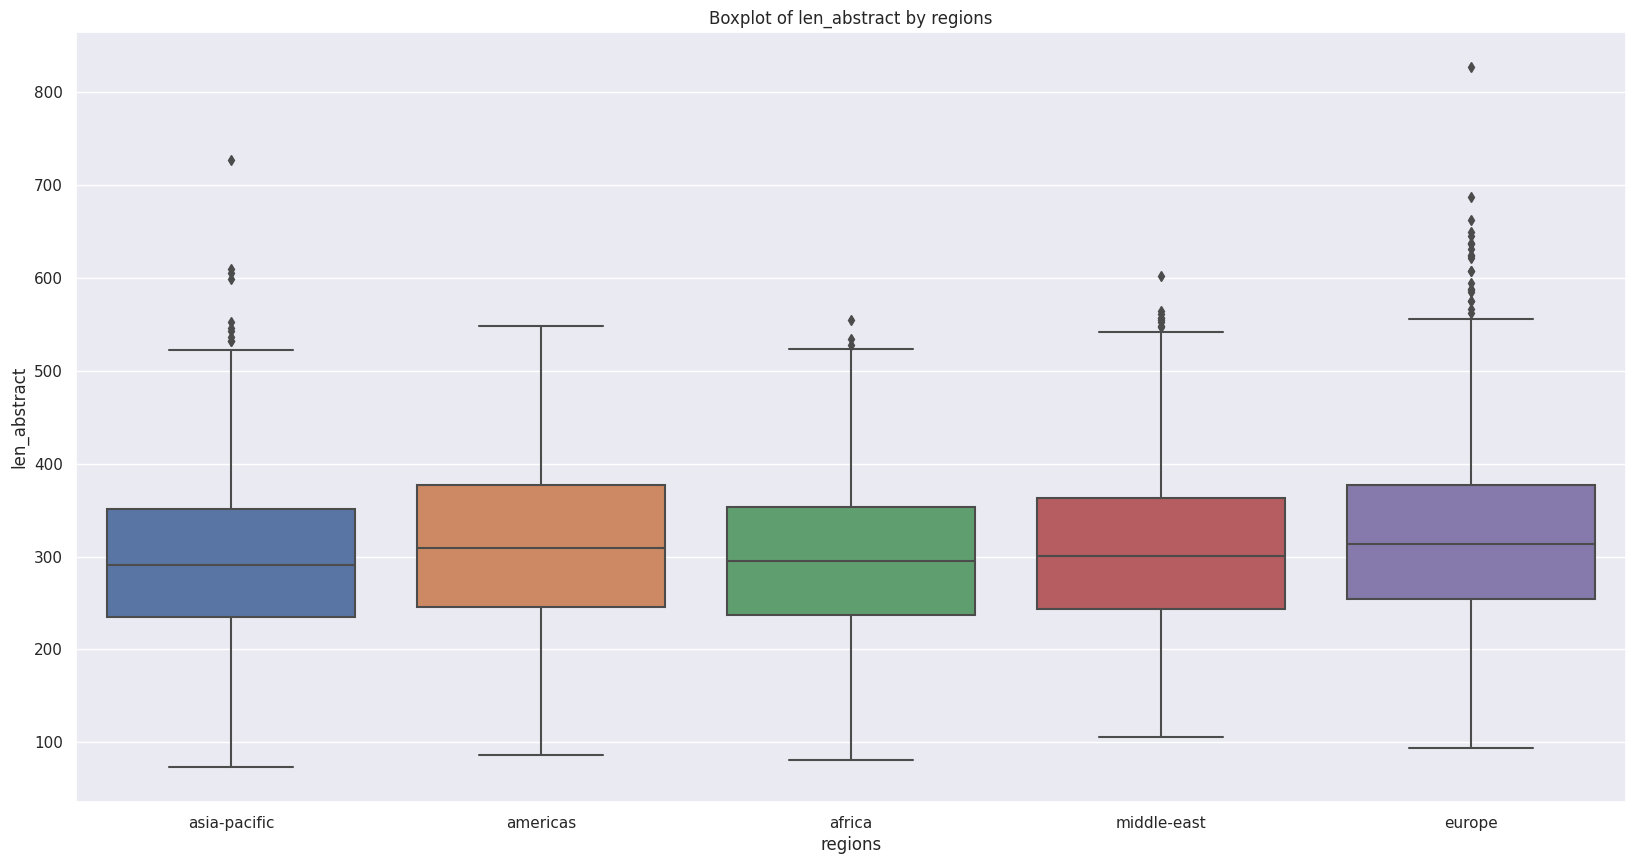

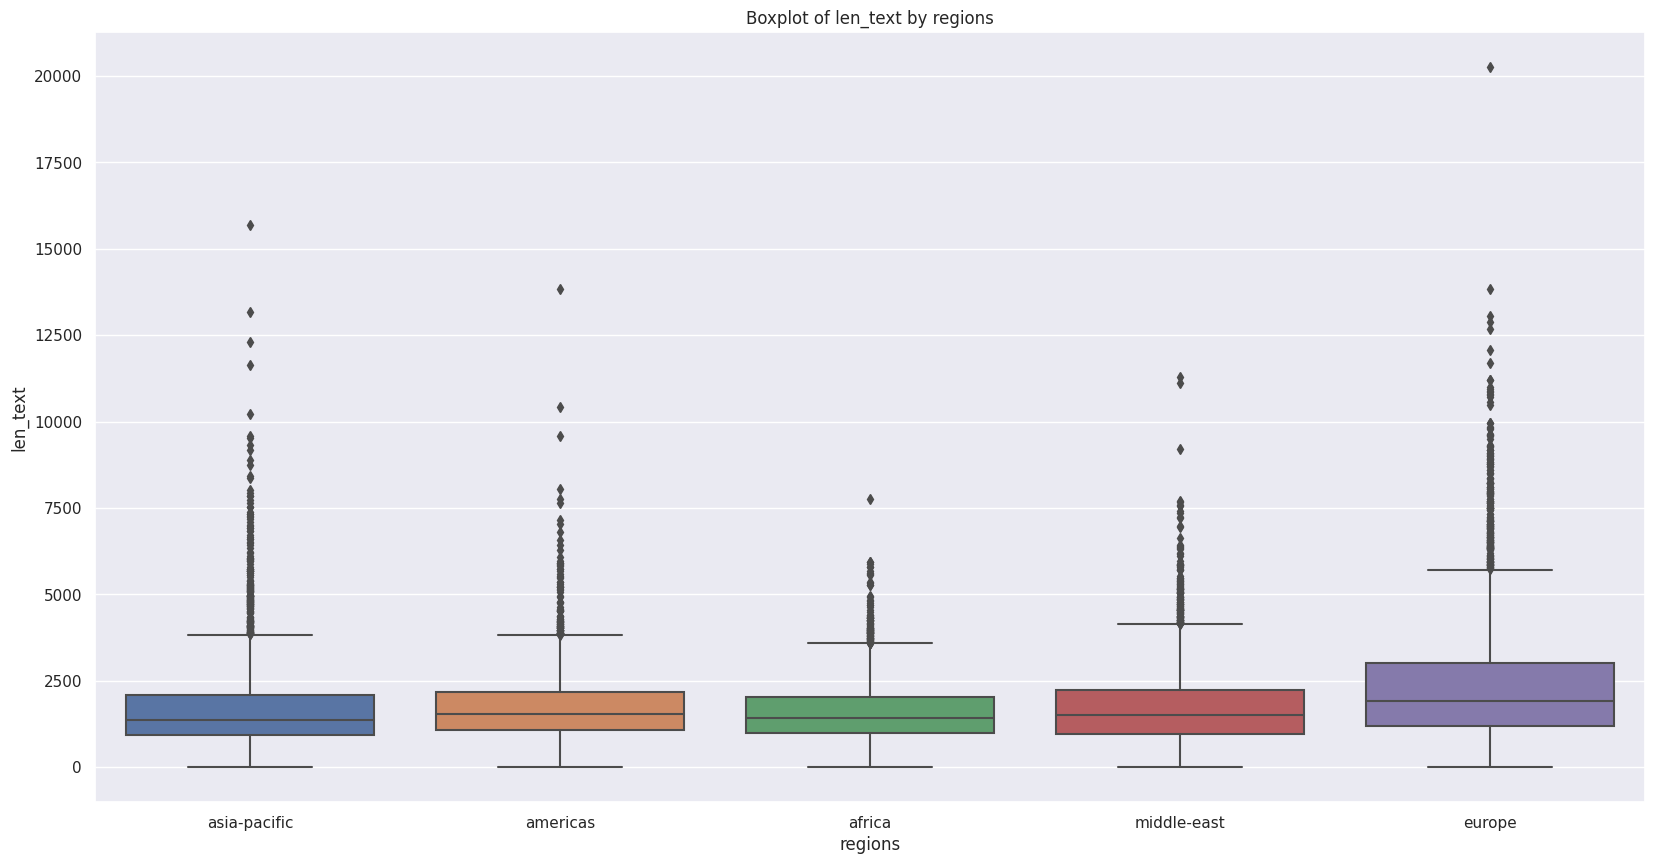

In [ ]:
for col in ["len_title", "len_abstract", "len_text"]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="regions", y=col, data=df, ax=ax)
    plt.title(f"Boxplot of {col} by regions");

Что можно заметить:
- В среднем длина заголовка по всем категориям около 65-70 символов
- Вступительный текст в среднем составляет 300 символов.
- Средняя длина основного текста варьирует чуть больше остальных параметров: примерно от 1500 до 2000 символов.
- Во всех параметрах и для всех категорий наблюдается большое количество заметные выбросов в сторону большего количества символов.

Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [ ]:
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "комментарий",
        "английский",
        "язык",
    ]
)

In [ ]:
for region in df.regions.unique():
    words = df[df.regions == region].title.str.split(" ").explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {region} region", fontsize=30)
    ax.imshow(wc, alpha=0.98)

Output hidden; open in https://colab.research.google.com to view.

На сайте отсутствует счетчик просмотров или возможность комментирования. Но все равно ради интереса можно посмотреть распределение возраста статей. Тем более, что размах возрастов в нашем случае очень широк - от дня до 20 лет.

In [ ]:
df["lifetime"] = df["date"].apply(
    lambda x: (datetime.datetime.now() - x).total_seconds()
)
df["lifetime"] = df["lifetime"].apply(lambda x: divmod(x, 60)[0])  # lifetime in minutes

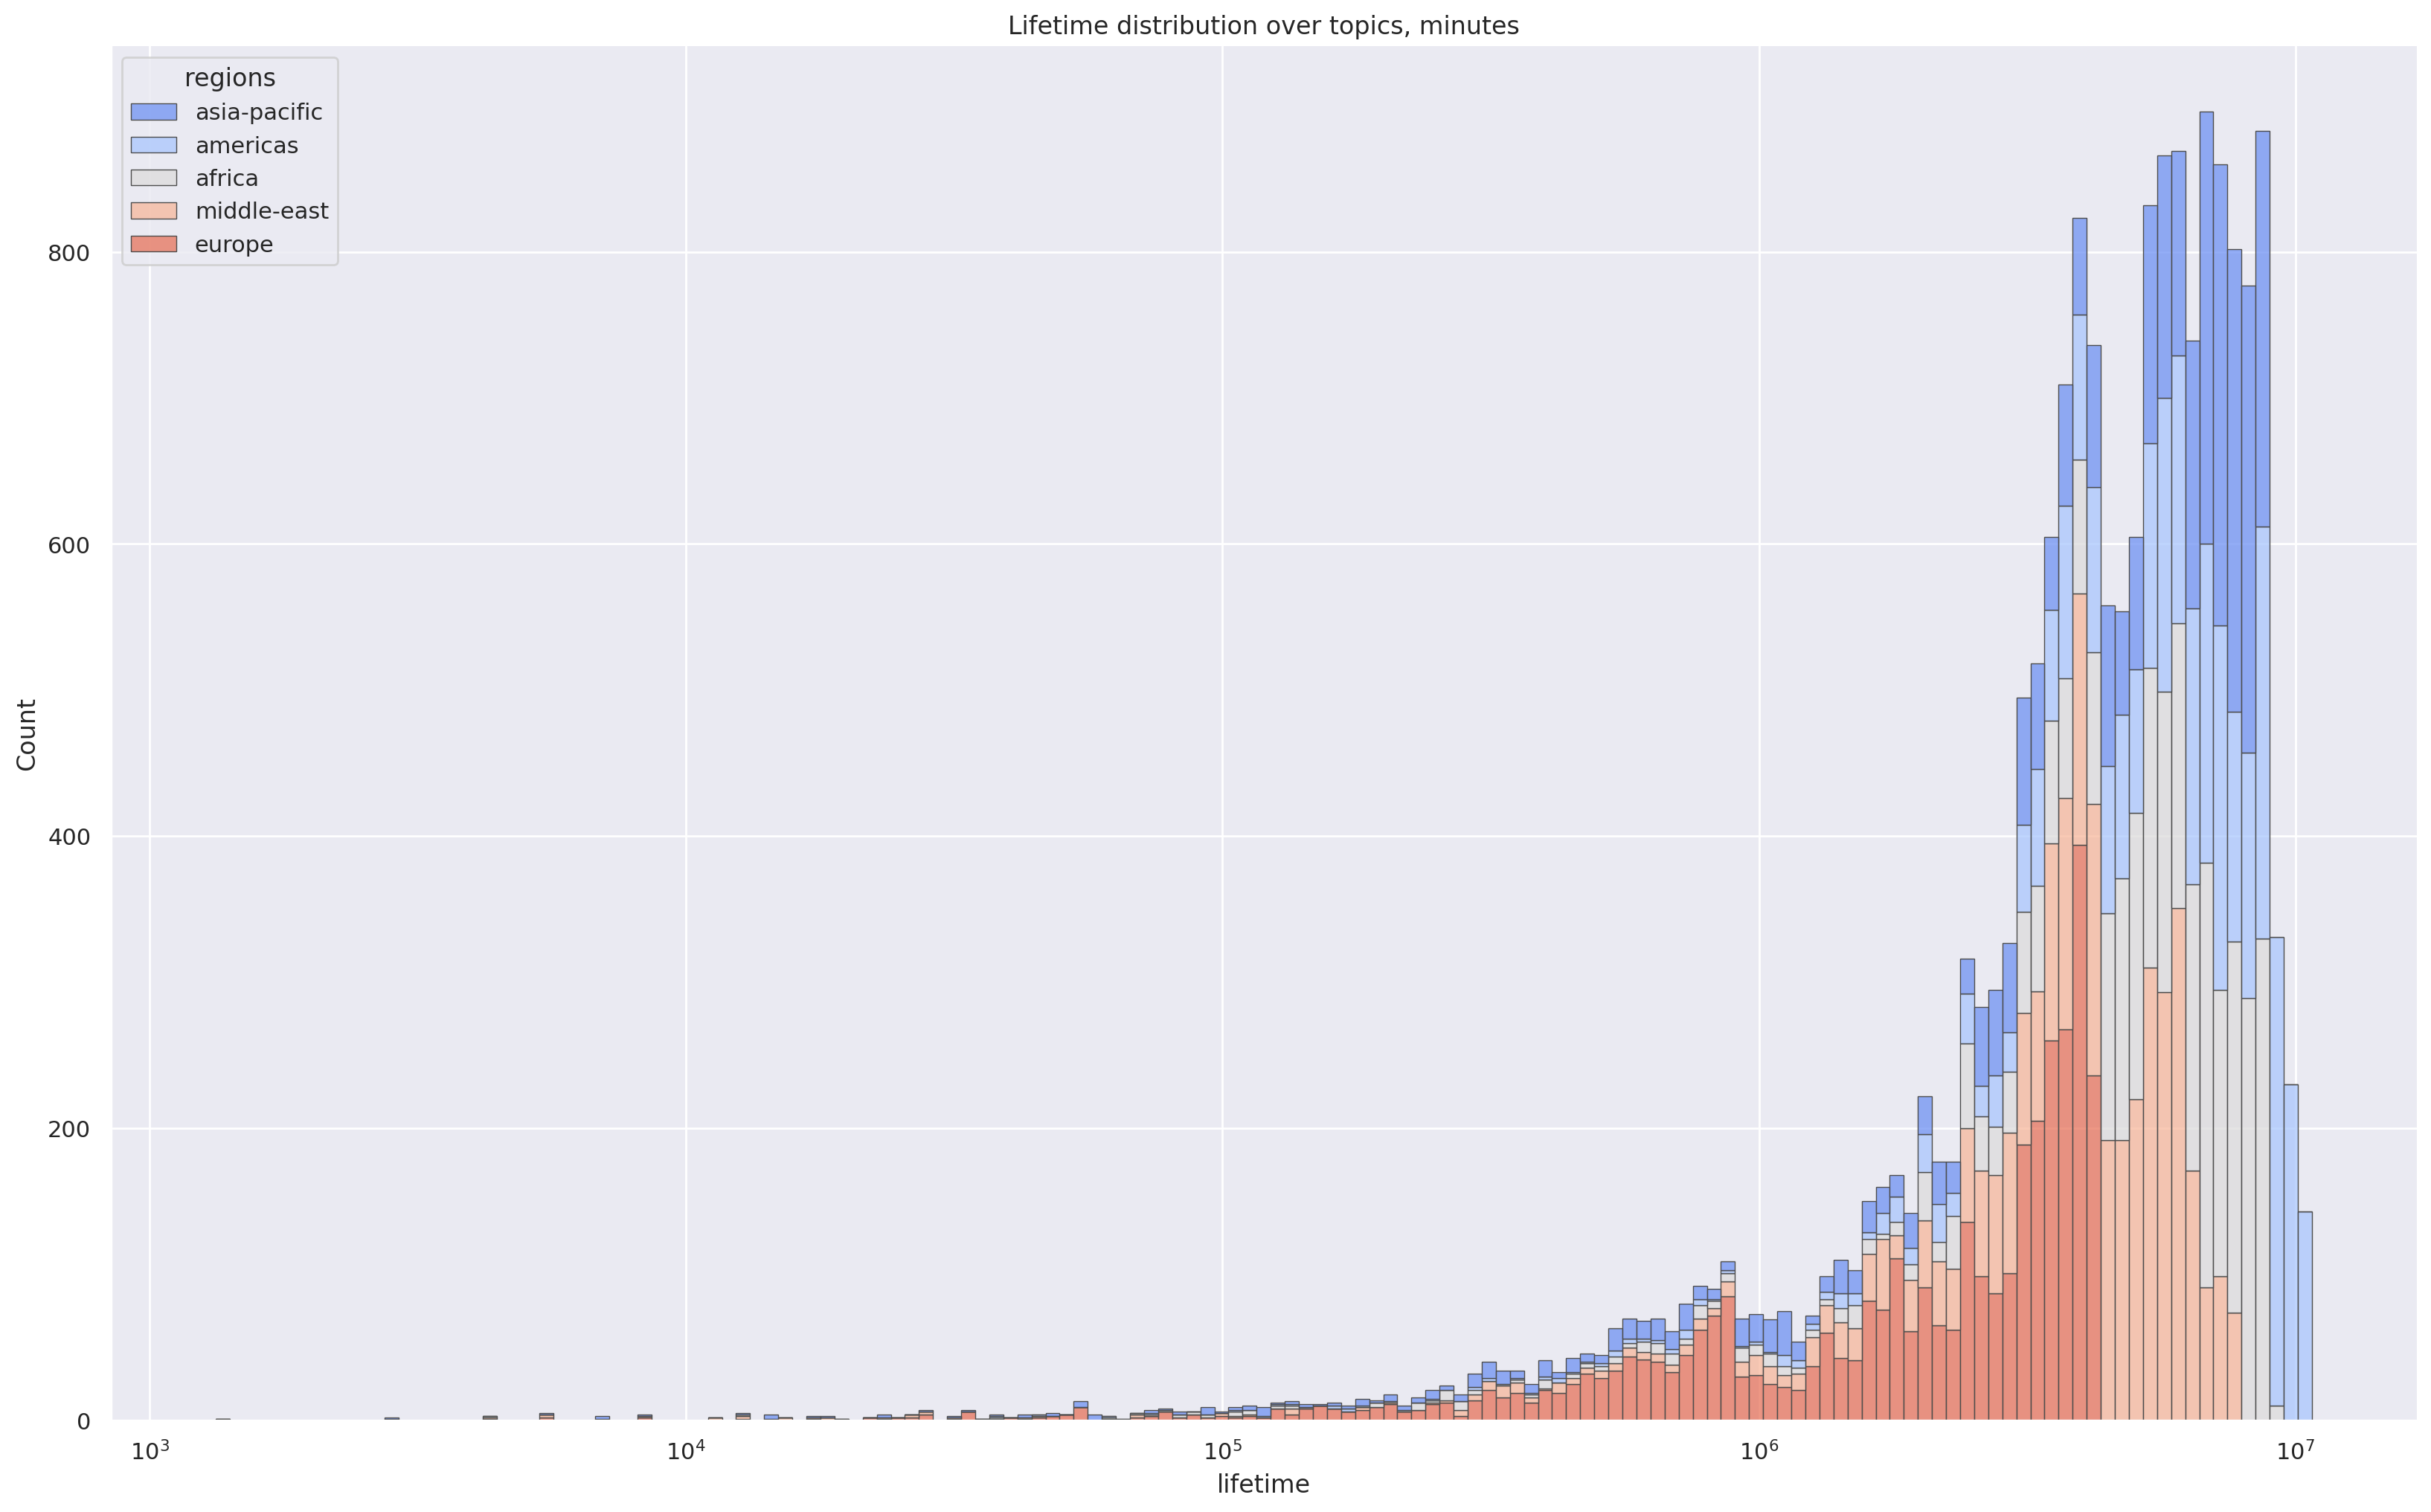

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="regions",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=0.5,
    log_scale=True,
)
axs.set_title("Lifetime distribution over topics, minutes");

В датасете присутствуют как старые статьи, так и новые. И само распределение имеет смещённое вправо распределение.
Стоит отметить, что разные категории имеют разное количество статей, публикуемых в год. Это отражается не только на распределении возраста, но и на выборке в целом. Для некотрых категорий статьи в целом моложе, чем у категорий, в которых статьи публикуются реже.

### Выводы

Итак, на данном этапе мы провели первичный анализ датасета. Статьи распределены по тематикам равномерно. Все новости относятся к временному диапозону от 2003 до 2023 года. Максимум статей приходится на 2016 год. Больше всего новостей пишется в Сентябре и Октябре. По дням недели на текущих данных меньше всего новостей выходит в выходные и больше всего в середине недели, хотя различия в рабочую неделю небольшие.

В среднем длина заголовка по всем категориям около 65-70 символов. Длина вступительного текста в среднем составляет в среднем 300 символов. Длина основного текста варьирует больше и в среднем примерно составляет 1500-2000 символов. Все перечисленные текстовые признаки в каждой категории имели большое количество выбросов в сторону больших значений.

Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

Поскольку мы работаем с текстами, на этом этапе пока не столь очевидно, какие данные и по какой причине стоит считать выбросами, а какие - особенностями конкретной тематики. Поэтому это мы оставим на следующие этапы работы над проектом.

## Часть 2. Векторизация текста и построение моделей

In [ ]:
!pip install natasha

In [ ]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
RND_STATE = 73

### Предобработка текста
Чтобы получить более точное и компактное представление текстов, обычно делают нормализацию текста, которая включает в себя следующие этапы:
- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

Для нас совершенно не важен регистр текста, его род и падеж, а также различные символы, которые и вовсе текстом не являются.

Таким образом, мы ожидаем, что после предобработки текста качество модели должно возрасти.

Существуют разные библиотеки для обработки текста, мы будем использовать Наташу, потому что она включяет в себя все необходимые нам элементы предобработки (токенизация и лемматизация), а также [демонстрирует сравнительно хорошее качество](https://github.com/natasha/naeval) при работе с русским языком.

In [ ]:
# Стоп-слова
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "комментарий",
        "английский",
        "язык",
    ]
)

In [ ]:
df = pd.read_pickle("df_regions.p", compression="gzip")

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

Напишем функцию, которая будет осуществлять всю указанную выше предобработку текста.

In [ ]:
def text_prep(text) -> str:
    doc = Doc(text)  # Преобразуем текст в объект класса документ
    doc.segment(segmenter)  # Сегментация
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:  # Токенизация
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]  # Лемматизация
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

Обработаем доступные нам текстовые поля.

In [ ]:
%%time
df["title_clean"] = df.title.apply(text_prep)
df["abstract_clean"] = df.abstract.apply(text_prep)
df["text_clean"] = df.text.apply(text_prep)

CPU times: user 25min 6s, sys: 14min 32s, total: 39min 38s
Wall time: 23min 24s


In [ ]:
# Сохранение датасета с обработанным текстом
df.to_pickle("df_regions_clean.p", compression="gzip")

In [ ]:
# Извлечение заранее сохраненного датасета с обработанным текстом
df = pd.read_pickle("df_regions_claen.p", compression="gzip")

Посмотрим, насколько разумно работает наша предобработка, оценив качество преобразования текстовых данных.

In [ ]:
# Заголовок
df.sample(1)[["title", "title_clean"]].values

array([['Совет Безопасности  ООН осудил вооруженные столкновения в Южном  Судане',
        'совет безопасность оон осудить вооружить столкновение южный судан']],
      dtype=object)

In [ ]:
# Вступительный текст
df.sample(1)[["abstract", "abstract_clean"]].values

array([['Сегодня, выступая на заседании  Совета Безопасности ООН, Генеральный секретарь Антониу Гутерриш заявил, что серьезные нарушения прав  человека -  это предвестники  надвигающихся конфликтов.  Глава ООН призвал активизировать  механизмы своевременной  реакции на первые признаки таких нарушений.',
        'сегодня выступать заседание совет безопасность оон генеральный секретарь антониу гутерриша заявить серьезный нарушение право человек предвестник надвигаться конфликт глава оон призвать активизировать механизм своевременный реакция первый признак нарушение']],
      dtype=object)

In [ ]:
# Основной текст
df.sample(1)[["text", "text_clean"]].values

array([['«Представители международного сообщества собрались для того, чтобы объявить о новых мерах, цель которых - помочь странам принимающим беженцев, предоставить самим беженцам возможность зарабатывать и обеспечивать себя, найти долгосрочное решения проблем тех, кто был вынужден покинуть свои дома, спасаясь от войн и преследований», - заявил Верховный комиссар ООН по делам беженцев Филиппо Гранди.\n\xa0\nНа первый в мире Глобальный форум по беженцам прибыли главы государств и правительств, дипломаты, высокопоставленные сотрудники международных организаций, руководители коммерческих компаний и представители гражданского общества. Во вторник к делегатам присоединятся Антониу Гутерриш, Генеральный секретарь ООН, а также Реджеп Тайип Эрдоган, президент Турции - страны, которая принимает миллионы сирийских беженцев.\nУсилия по защите беженцев сегодня актуальны как никогда: по всему миру свои дома были вынуждены покинуть более 70 млн человек. Почти 26 млн из них ищут убежища в других стра

#### Word2Vec

Давайте теперь применим альтернативный подход к представлению слов - Word2Vec. Этот метод основывается на семантической близости слов. Построим модель на нашей выборке новостей.

In [ ]:
# Инициализируем и обучаем модель
model = Word2Vec(
    sentences=df.title_clean.str.split(),
    vector_size=300,
    min_count=10,
    window=2,
    seed=RND_STATE,
)

Посмотрим, насколько разумные у нас получились вектора.

In [ ]:
model.wv.most_similar(positive=["дискриминация"])

[('расовый', 0.850817859172821),
 ('нетерпимость', 0.7908344268798828),
 ('ксенофобия', 0.782447099685669),
 ('стигма', 0.7766197919845581),
 ('стигматизация', 0.7755682468414307),
 ('стереотип', 0.7708917260169983),
 ('расизм', 0.7488859295845032),
 ('несправедливость', 0.747432291507721),
 ('ориентация', 0.7266941070556641),
 ('предрассудок', 0.7223610281944275)]

В целом все логично: близкие вектора - это воктора слов, обозначающих признаки и эмоции, ассоциированые с поражением в правах.

In [ ]:
model.wv.most_similar(positive=["европа"])

[('страна', 0.9897197484970093),
 ('африка', 0.9786477088928223),
 ('восточный', 0.9763705134391785),
 ('западный', 0.9630959033966064),
 ('регион', 0.9624472856521606),
 ('тихий', 0.9587430953979492),
 ('процент', 0.9554204344749451),
 ('кризис', 0.9547819495201111),
 ('рог', 0.9546507000923157),
 ('бедствие', 0.9512506723403931)]

Также выглядит логично. Имеем близкие вектора слов, связанные с географией и сторонами света.

In [ ]:
model.wv.most_similar(positive=["право"])

[('нарушение', 0.9237785339355469),
 ('человек', 0.8360722064971924),
 ('верховный', 0.8247866630554199),
 ('защита', 0.821769118309021),
 ('инвалид', 0.7914423942565918),
 ('грубый', 0.7711666822433472),
 ('ситуация', 0.7327834367752075),
 ('комиссар', 0.7244425415992737),
 ('конвенция', 0.7235170602798462),
 ('обзор', 0.7011826634407043)]

Видим, что все выглядит отчасти логично.

Чтобы построить модель, нам нужно получить вектора для предложения. Это можно сделать двумя способами:
- Усреднить вектора слов, входящих в предложение
- Взвесить вектора слов, входящих в предложение на основании их tf-idf весов

Важно заметить, что здесь легко совершить методологическую ошибку. Ранее мы обучали вектора на всей выборке, а теперь для валидации сделаем честный эксперимент и обучим только на тренировочной.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.text_clean.str.split(), df.regions.values, random_state=RND_STATE
)

model = Word2Vec(
    sentences=X_train, vector_size=200, min_count=10, window=2, seed=RND_STATE
)

#####Подход с Tf-Idf

In [ ]:
# Векторизация и преобразование векторов слов на основании их tf-idf весов
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""

    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()]
        )

        return self

    def transform(self, X):
        return np.array(
            [
                np.mean(
                    [
                        self.word2vec.get_vector(w) * self.word2weight[w]
                        for w in words
                        if w in self.word2vec
                    ]
                    or [np.zeros(self.dim)],
                    axis=0,
                )
                for words in X
            ]
        )

#####Подход с усреднением векторов

In [ ]:
# Векторизация и преобразование (усреднение) векторов слов
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""

    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array(
            [
                np.mean(
                    [self.word2vec.get_vector(w) for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)],
                    axis=0,
                )
                for words in X
            ]
        )

Для того, чтобы по-прежнему использовать `Pipeline`, оформим описанные выше подходы в классы.

###Логистическая регрессия

In [ ]:
# Построение модели
Log_Mean = Pipeline(
    [
        ("w2v", MeanEmbeddingVectorizer(model)),
        ("clf", LogisticRegression(random_state=RND_STATE, max_iter=1000)),
    ]
)

Log_Mean.fit(X_train, y_train)

print(classification_report(y_test, Log_Mean.predict(X_test)))

              precision    recall  f1-score   support

      africa       0.73      0.75      0.74       907
    americas       0.64      0.65      0.64       926
asia-pacific       0.63      0.58      0.61       906
      europe       0.68      0.69      0.68       925
 middle-east       0.78      0.78      0.78       947

    accuracy                           0.69      4611
   macro avg       0.69      0.69      0.69      4611
weighted avg       0.69      0.69      0.69      4611



In [ ]:
y_pred = Log_Mean.predict(X_test)

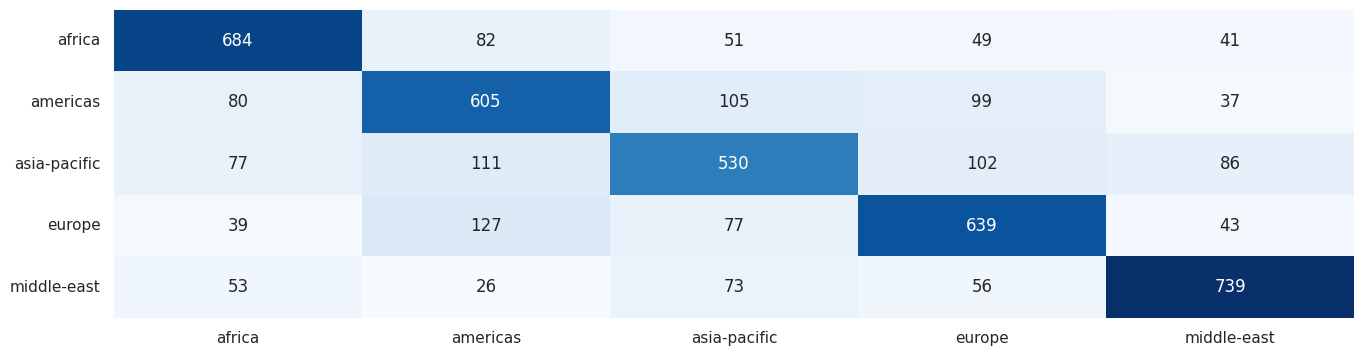

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=Log_Mean.classes_)

cm_df = pd.DataFrame(data=cm, columns=Log_Mean.classes_, index=Log_Mean.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

У нас получилась средние значения полноты и точности. Хуже всего модель предсказыает категорию статей, относящихся к  `asia-pacific`. Результат сомнительный.

In [ ]:
# Построение модели
Log_Tf_Idf = Pipeline(
    [
        ("w2v", TfidfEmbeddingVectorizer(model)),
        ("clf", LogisticRegression(random_state=RND_STATE, max_iter=10000)),
    ]
)

Log_Tf_Idf.fit(X_train, y_train)

print(classification_report(y_test, Log_Tf_Idf.predict(X_test)))

              precision    recall  f1-score   support

      africa       0.76      0.77      0.77       907
    americas       0.65      0.68      0.66       926
asia-pacific       0.68      0.65      0.66       906
      europe       0.71      0.71      0.71       925
 middle-east       0.81      0.80      0.80       947

    accuracy                           0.72      4611
   macro avg       0.72      0.72      0.72      4611
weighted avg       0.72      0.72      0.72      4611



Результаты примерно те же, с небольшщими улучшениями. Параметры полноты и точности возрасли в каждой категории. Категория `asia-pacifics` все еще хуже всех предсказывается, а лучше всего у статей с категорией `middle-east`. Попрбуем при последующих решениях задачи классификации использовать именно подход Tf-Idf.

In [ ]:
y_pred = Log_Tf_Idf.predict(X_test)

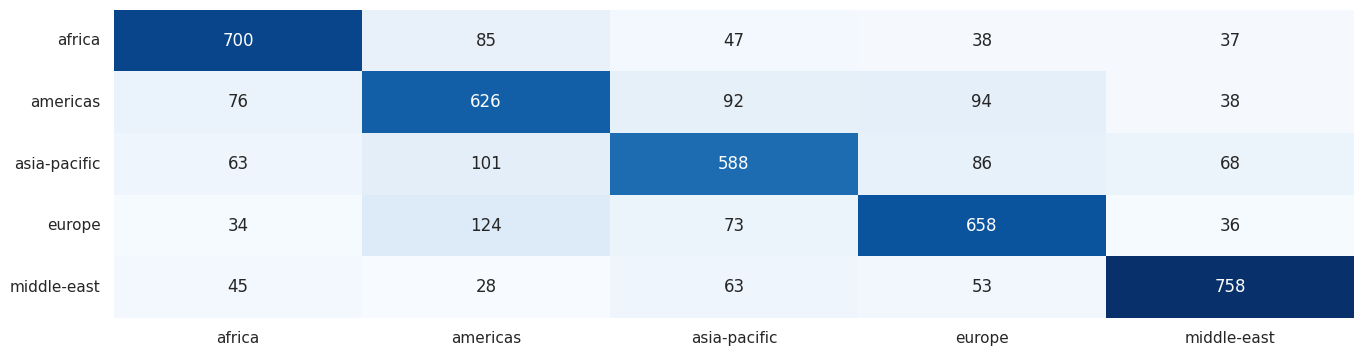

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=Log_Tf_Idf.classes_)

cm_df = pd.DataFrame(data=cm, columns=Log_Tf_Idf.classes_, index=Log_Tf_Idf.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

###Метод опорных векторов SVM

In [ ]:
# Построение модели
SVC_model = Pipeline(
    [
        ("w2v", TfidfEmbeddingVectorizer(model)),
        ("clf", SVC(random_state=RND_STATE, max_iter=10000)),
    ]
)

SVC_model.fit(X_train, y_train)

print(classification_report(y_test, SVC_model.predict(X_test)))

              precision    recall  f1-score   support

      africa       0.78      0.75      0.76       907
    americas       0.64      0.69      0.66       926
asia-pacific       0.65      0.62      0.64       906
      europe       0.69      0.71      0.70       925
 middle-east       0.81      0.79      0.80       947

    accuracy                           0.71      4611
   macro avg       0.71      0.71      0.71      4611
weighted avg       0.72      0.71      0.71      4611



In [ ]:
y_pred = SVC_model.predict(X_test)

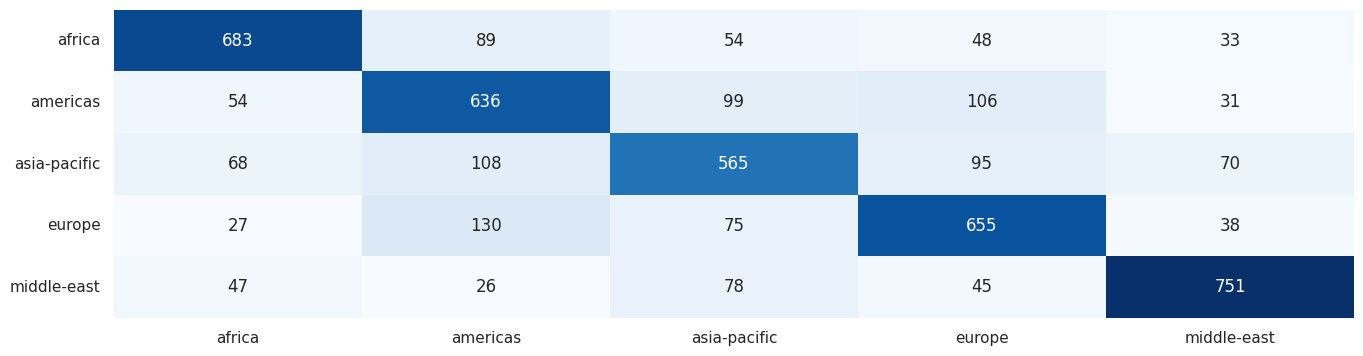

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=SVC_model.classes_)

cm_df = pd.DataFrame(data=cm, columns=SVC_model.classes_, index=SVC_model.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

Эта модель немного уступает предыдущей.

###Наивный байесовский метод


In [ ]:
# Построение модели
from sklearn.naive_bayes import GaussianNB

Bayesian = Pipeline([("w2v", TfidfEmbeddingVectorizer(model)), ("clf", GaussianNB())])

Bayesian.fit(X_train, y_train)

print(classification_report(y_test, Bayesian.predict(X_test)))

              precision    recall  f1-score   support

      africa       0.65      0.57      0.61       907
    americas       0.48      0.56      0.51       926
asia-pacific       0.47      0.14      0.21       906
      europe       0.44      0.54      0.48       925
 middle-east       0.54      0.75      0.63       947

    accuracy                           0.51      4611
   macro avg       0.51      0.51      0.49      4611
weighted avg       0.51      0.51      0.49      4611



In [ ]:
y_pred = Bayesian.predict(X_test)

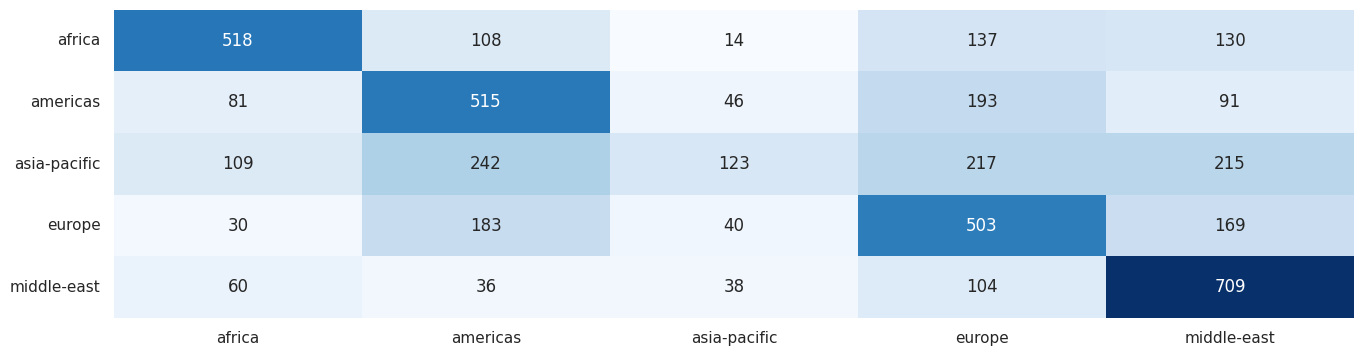

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=Bayesian.classes_)

cm_df = pd.DataFrame(data=cm, columns=Bayesian.classes_, index=Bayesian.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

Пожалуй, это худщшая модель из трёх. Самая проблемная категория `asia-pacific` здесь как лакмусовая бумажка, очень плохо предсказывается.

###Выводы

Наилучшей моделью для данных из трёх используемых - это старая-добрая логистическая регрессия с подходом Tf-Idf. Она характеризуется средними показателями точности и полноты. Худшая модель - наивный байес.
Наиболее плохо предсказываемая категория - `asia-pacific`, еаиболее точно предсказываемая категория - `middle-east`

Ошибки моделей вероятно связаны с общими наиболее частотными словам, а также фактом того, что в одной статье могт упоминаться страны из разных категорий. Также были две статьи, что относились к двум категориям сразу. Несмотря на то, что повторения были удалены, само их наличие на сайте подразумевает пересечение контекстов для некоторых категорий, которое неминумо повлияет на предсказательную силу модели.